# Listing 1
## Listing the OpenAI Gym environments

In [1]:
from gym import envs
envs.registry.all()

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

# Listing 2
## Creating an environment in OpenAI Gym

In [2]:
import gym
env = gym.make('CartPole-v0')

# Listing 3
## Taking an action in CartPole

In [3]:
state1 = env.reset()
action = env.action_space.sample()
state, reward, done, info = env.step(action)

# Listing 4
## Setting up the policy network

In [4]:
import numpy as np
import torch
from matplotlib import pylab as plt

l1 = 4 # the input data is length 4
l2 = 150 # the middle layer produces a vector of length 150
l3 = 2 # the output is a 2-length vector for the left and right actions

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.Softmax() # the output is a softmax probability distribution over actions
)

learning_rate = 0.0009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Listing 5
## Using the policy network to sample an action

In [6]:
pred = model(torch.from_numpy(state1).float()) # calls the policy network model to produce predicted action probabilities
action = np.random.choice(np.array([0, 1]), p=pred.data.numpy()) # samples an action from the probability distribution produced by the policy network
state2, reward, done, info = env.step(action) # takes the action and receives the new state and reward. The info variable is produced by the environment but is irrelevant

C:\Users\Utilizador\anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


# Listing 6
## Computing the discounted rewards

In [7]:
def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards)
    disc_return = torch.pow(gamma, torch.arange(lenr).float()) * rewards # computes exponencially decaying rewards
    disc_return /= disc_return.max() # normalizes the rewards to be within the [0, 1] interval to improve numerical stability
    return disc_return

# Listing 7
## Defining the loss function

In [8]:
def loss_fn(preds, r): # the loss function expects an array of action probabilities for the actions that were taken and the discounted rewards
    return -torch.sum(r * torch.log(preds)) # computes the log of the probabilities, multiplies by the discounted rewards, sums them all and flips the sign

# Listing 8
## The REINFORCE training loop

In [20]:
MAX_DUR = 200
MAX_EPISODES = 1000
gamma = 0.99
score = [] # a list to keep track of the episode length over training time

for episode in range(MAX_EPISODES):
    curr_state = env.reset()
    done = False
    transitions = [] # a list of state, action, rewards (but we ignore the reward)
    
    for t in range(MAX_DUR): # while in the episode
        act_prob = model(torch.from_numpy(curr_state).float()) # gets the action probabilities
        action = np.random.choice(np.array([0, 1]), p=act_prob.data.numpy()) # selects an action stochastically
        prev_state = curr_state
        curr_state, _, done, info = env.step(action) # takes the action in the environment
        transitions.append((prev_state, action, t+1)) # stores this transition 
        if done: # if the game is lost, breaks out of the loop
            break
            
    ep_len = len(transitions) # stores the episode length
    score.append(ep_len)
    reward_batch = torch.Tensor([r for (s, a, r) in transitions]).flip(dims=(0,)) # collects all the rewards in the episode in a single tensor
    disc_rewards = discount_rewards(reward_batch) # computes the discounted version of the rewards
    state_batch = torch.Tensor([s for (s, a, r) in transitions]) # collects the states in the episode in a single tensor
    action_batch = torch.Tensor([a for (s, a, r) in transitions]) # collects the actions in the episodie in a single tensor
    pred_batch = model(state_batch) # recomputes the action probabilities for all the states in the episode
    prob_batch = pred_batch.gather(dim=1, index=action_batch.long().view(-1, 1)).squeeze() # subsets the action probabilities associated with the actions that were actually taken
    loss = loss_fn(prob_batch, disc_rewards)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [21]:
def running_mean(x, N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

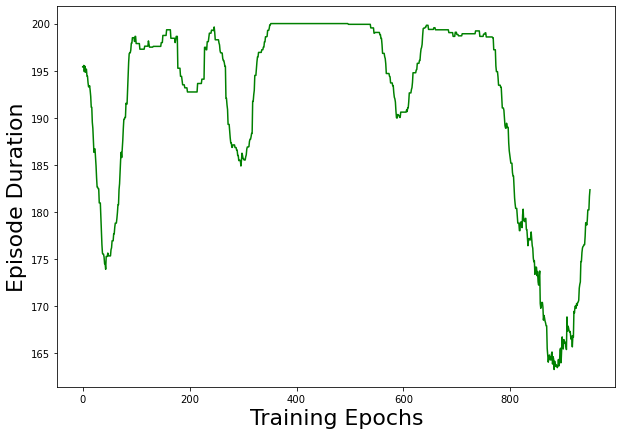

In [22]:
score = np.array(score)
avg_score = running_mean(score, 50)

plt.figure(figsize=(10, 7))
plt.ylabel("Episode Duration", fontsize=22)
plt.xlabel("Training Epochs", fontsize=22)
plt.plot(avg_score, color='green')

# Listing 9 (Extra)
## Testing the Policy Network

In [23]:
score = []
games = 100
wins = 0
done = False
state1 = env.reset()
for i in range(games):
    t = 0
    while not done:
        pred = model(torch.from_numpy(state1).float())
        action = np.random.choice(np.array([0, 1]), p=pred.data.numpy())
        state2, reward, done, info = env.step(action)
        state1 = state2
        t += 1
        if t > MAX_DUR:
            break
            
    if t == 200:
        wins += 1
            
    state1 = env.reset()
    done = False
    score.append(t)

score = np.array(score)

C:\Users\Utilizador\anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


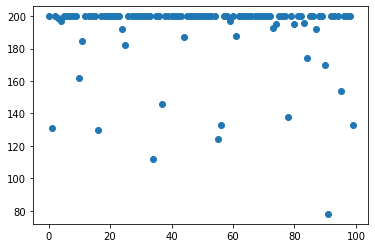

In [24]:
plt.scatter(np.arange(score.shape[0]), score)

In [25]:
print("Games Played: {0}, Wins: {1}".format(len(score), wins))

Games Played: 100, Wins: 74
